<a href="https://colab.research.google.com/github/Nit-Rathore/Satellite-Image-Classification-and-Urban-Growth-Modelling/blob/main/Satellite_Image_Classification_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install pyrsgis
from pyrsgis import raster, convert
from osgeo import gdal
from google.colab import drive
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import models,losses
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
multispectral_Bangalore = '/content/drive/MyDrive/Dataset_Satellite/Bangalore_1997clip.tif'
classes_Bangalore = '/content/drive/MyDrive/Dataset_Satellite/Train_1997.tif'
multispectral_Bangalore_1998 = '/content/drive/MyDrive/Dataset_Satellite/Bangalore_1998clip.tif'
test_Bangalore = '/content/drive/MyDrive/Dataset_Satellite/Test_1997.tif'


In [31]:
# Reading all the imported tif files
ds1, features_97 = raster.read(multispectral_Bangalore, bands = 'all')
print('Bangalore Multispectral image shape', features_97.shape)

ds2, labels = raster.read(classes_Bangalore, bands = 1)
print('Bangalalore mutliclass image shape', labels.shape)

ds3, test_values = raster.read(test_Bangalore, bands = 1)
print('Bangalore test dataset image shape',test_values.shape)

ds4, features_98 = raster.read(multispectral_Bangalore_1998, bands = 'all')
print('Bangalore 1998 multispectral image shape', features_98.shape)

Bangalore Multispectral image shape (5, 2068, 2268)
Bangalalore mutliclass image shape (2068, 2268)
Bangalore test dataset image shape (2068, 2268)
Bangalore 1998 multispectral image shape (5, 2068, 2268)


In [32]:
featuresBangalore_1997 = convert.array_to_table(features_97)
labels = convert.array_to_table(labels)
test = convert.array_to_table(test_values)
featuresBangalore_1998 = convert.array_to_table(features_98)

print(set(featuresBangalore_1997.flatten()))
print(set(labels))

#To extract the pixels with the required label values
features_1997 = np.rollaxis(featuresBangalore_1997,0,1)

{1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 

In [33]:
lab = labels.flatten()
test = test.flatten()

built_up = lab[lab==0]
veg = lab[lab==1]
water = lab[lab==2]
barren = lab[lab==3]

built_f = features_1997[lab==0]
veg_f = features_1997[lab==1]
water_f = features_1997[lab==2]
barren_f = features_1997[lab==3]

built_t = test[test==0]
veg_t = test[test==1]
water_t = test[test==2]
barren_t = test[test==3]

built_testf = features_1997[test==0]
veg_testf = features_1997[test==1]
water_testf = features_1997[test==2]
barren_testf = features_1997[test==3]

In [34]:
features = np.concatenate((built_f,veg_f,water_f,barren_f), axis=0)
labels = np.concatenate((built_up,veg,water,barren), axis=0)
test_val = np. concatenate((built_t,veg_t,water_t,barren_t), axis=0)
test_features = np.concatenate((built_testf,veg_testf,water_testf,barren_testf), axis=0)

In [35]:
#To check if the dimension of input data to the model matches
print('Reshaped Bangalore data with features ',features.shape)
print('Reshaped Bangalore data with labels', labels.shape)
print('Reshaped Bangalore data with test features', test_features.shape)
print('Reshaped Bangalore data with test labels', test_val.shape)

Reshaped Bangalore data with features  (5857, 5)
Reshaped Bangalore data with labels (5857,)
Reshaped Bangalore data with test features (1072, 5)
Reshaped Bangalore data with test labels (1072,)


In [36]:
xTrain, yTrain = features, labels
yPred = test_features/255.0
yTest = test_val

xTrain = xTrain/255.0
featuresBangalore_1997 = features_1997/255.0
featuresBangalore_1998 = featuresBangalore_1998/255.0

xTrain = xTrain.reshape((xTrain.shape[0], 1, xTrain.shape[1]))
yPred = yPred.reshape((yPred.shape[0], 1, yPred.shape[1]))
featuresBangalore_1997 = featuresBangalore_1997.reshape((features_1997.shape[0], 1, features_1997.shape[1]))
featuresBangalore_1998 = featuresBangalore_1998.reshape((featuresBangalore_1998.shape[0], 1, featuresBangalore_1998.shape[1]))

In [37]:
# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, 5)),
    keras.layers.Dense(19, activation='relu'),
    keras.layers.Dense(10,activation = 'relu'),
    keras.layers.Dense(4, activation='linear')
    ])

model.compile (optimizer= keras.optimizers.Adam(learning_rate = 0.001), 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
              metrics=['sparse_categorical_accuracy']
              )


In [38]:
history = model.fit(xTrain,yTrain,epochs=30)

Epoch 1/50
184/184 [==============================] - 1s 2ms/step - loss: 1.2225 - sparse_categorical_accuracy: 0.4335
Epoch 2/50
184/184 [==============================] - 0s 2ms/step - loss: 0.8896 - sparse_categorical_accuracy: 0.6268
Epoch 3/50
184/184 [==============================] - 0s 2ms/step - loss: 0.7003 - sparse_categorical_accuracy: 0.6954
Epoch 4/50
184/184 [==============================] - 0s 2ms/step - loss: 0.5798 - sparse_categorical_accuracy: 0.8216
Epoch 5/50
184/184 [==============================] - 0s 2ms/step - loss: 0.5042 - sparse_categorical_accuracy: 0.8511
Epoch 6/50
184/184 [==============================] - 0s 2ms/step - loss: 0.4604 - sparse_categorical_accuracy: 0.8677
Epoch 7/50
184/184 [==============================] - 0s 2ms/step - loss: 0.4269 - sparse_categorical_accuracy: 0.8750
Epoch 8/50
184/184 [==============================] - 0s 2ms/step - loss: 0.3991 - sparse_categorical_accuracy: 0.8795
Epoch 9/50
184/184 [============================

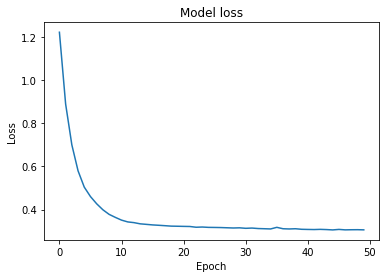

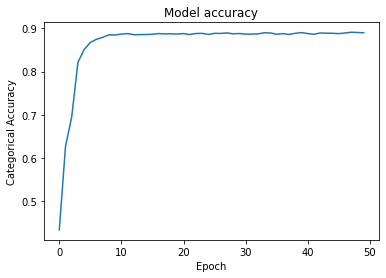

In [39]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

plt.plot(history.history['sparse_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Categorical Accuracy')
plt.xlabel('Epoch')
plt.show()

In [60]:
yTestPred = model.predict(yPred)
yTestPredicted = []

for i in range(len(yTestPred)):
  value = yTestPred[i].argmax()
  yTestPredicted.append(value)

cMatrix = confusion_matrix(yTest,yTestPredicted)
precision = precision_score(yTest,yTestPredicted, average = 'weighted') 
recall = recall_score(yTest,yTestPredicted, average = 'weighted')
print("The confusion matrix for the 4 classes are: ")
print(cMatrix)
print("\nPrecision value: ",precision)
print("Recall value: ",recall)
print("F1-Score: " ,(2*precision*recall/(precision+recall)))

The confusion matrix for the 4 classes are: 
[[441  36   0   3]
 [  0 150   0  26]
 [  3   2 290   1]
 [  0   4   0 116]]

Precision value:  0.938058976222184
Recall value:  0.9300373134328358
F1-Score:  0.9340309221944308


In [ ]:
predicted_97 = model.predict(featuresBangalore_1997)
predicted_98 = model.predict(featuresBangalore_1998)

predicted_97 = np.array(predicted_97)
predicted_98 = np.array(predicted_98)

print('Dimensions of 1997 image: ',predicted_97.shape)
print('Dimensions of 1998 image: ',predicted_98.shape)

In [ ]:
pred= []

for i in range(len(predicted_97)):
  value = predicted_97[i].argmax()
  pred.append(value)

pred_2 = []
for i in range(len(predicted_98)):
  value = predicted_98[i].argmax() 
  pred_2.append(value)

print(set(pred))
print(set(pred_2))

{0, 1, 2, 3}
{0, 1, 2, 3}


In [ ]:
pred = np.array(pred, dtype = 'int')
pred_2 = np.array(pred_2, dtype = 'int')

predicted = convert.table_to_array(pred,n_rows=ds3.RasterYSize, n_cols=ds3.RasterXSize)
predicted_2 = convert.table_to_array(pred_2,n_rows=ds1.RasterYSize, n_cols=ds1.RasterXSize)

raster.export(predicted, ds1, filename='Classified_1997.tif',dtype='int',bands=1)
raster.export(predicted_2,ds3, filename='Classified_1998.tif',dtype='int',bands=1)